### Requirement

In [21]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model

import pandas as pd

---

#### Data 준비

- 의류(parent_category) 중 max 3350개씩 샘플링한 카테고리중 가장 많은 이미지를 보유하고 있는 카테고리 찾기

In [2]:
path = f'C:/Users/sanghui/Desktop/toyproject/DL_Project_5/hsh/data/crop_resize/train/2'

max = len(os.listdir(f'{path}/11'))

for category_id in os.listdir(path):
    if len(os.listdir(f'{path}/{category_id}')) >= max:
        max_category_id = category_id

max_category_id, len(os.listdir(f'{path}/{max_category_id}'))

('39', 3134)

In [3]:
max_path = f'C:/Users/sanghui/Desktop/toyproject/DL_Project_5/hsh/data/crop_resize/train/2/{max_category_id}'

In [4]:
# load data
samples = []

for image in os.listdir(max_path):
    path = max_path + '/' + image
    src = cv2.imread(path, cv2.IMREAD_COLOR)
    samples.append(src)

samples = np.array(samples)
samples.shape

(3134, 224, 224, 3)

----

### Modeling

#### VGG16

In [10]:
base_model = VGG16(weights='imagenet', include_top=True)
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [11]:
model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc1').output)

In [12]:
samples[0].shape

(224, 224, 3)

In [13]:
# feature extraction test
img_data = np.expand_dims(samples[0], axis=0)
img_data = preprocess_input(img_data)

vgg16_features = model.predict(img_data)

vgg16_features.shape


(1, 4096)

In [16]:
vgg16_features[0]

array([ 0.       ,  0.       ,  0.       , ..., 13.419567 ,  0.       ,
       10.5069685], dtype=float32)

In [17]:
# whole data
features = []

for sample in tqdm_notebook(samples):
    img_data = np.expand_dims(sample, axis=0)
    img_data = preprocess_input(img_data)

    features.append(model.predict(img_data)[0])

C:\Users\sanghui\AppData\Local\Temp/ipykernel_10860/2798714378.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for sample in tqdm_notebook(samples):


  0%|          | 0/3134 [00:00<?, ?it/s]

In [19]:
# calculate cosine similarity
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(features, features)
cosine_sim.shape

(3134, 3134)

In [22]:
vgg16_result = pd.DataFrame(cosine_sim, columns=os.listdir(max_path), index=os.listdir(max_path))

In [23]:
vgg16_result.head()

,0.jpg,1.jpg,10.jpg,100.jpg,1000.jpg,1001.jpg,1002.jpg,1003.jpg,1004.jpg,1005.jpg,...,990.jpg,991.jpg,992.jpg,993.jpg,994.jpg,995.jpg,996.jpg,997.jpg,998.jpg,999.jpg
0.jpg,1.000000,0.375351,0.261888,0.738329,0.333565,0.274307,0.284259,0.150765,0.389495,0.267152,...,0.275050,0.327296,0.747292,0.541403,0.289302,0.250939,0.188833,0.256985,0.424455,0.315173
1.jpg,0.375351,1.000000,0.463320,0.359859,0.342365,0.329104,0.260270,0.104841,0.469341,0.499791,...,0.304857,0.445052,0.391862,0.366084,0.483854,0.313011,0.217681,0.146438,0.337827,0.447529
10.jpg,0.261888,0.463320,1.000000,0.330885,0.391816,0.353430,0.338961,0.143989,0.356078,0.572879,...,0.321170,0.411480,0.338016,0.317627,0.510080,0.395243,0.271309,0.141949,0.296578,0.516686
100.jpg,0.738329,0.359859,0.330885,1.000000,0.382481,0.319617,0.291781,0.166516,0.456202,0.293240,...,0.275434,0.319786,0.808818,0.598480,0.312091,0.316899,0.229331,0.221056,0.512132,0.299169
1000.jpg,0.333565,0.342365,0.391816,0.382481,1.000000,0.304297,0.372040,0.195219,0.338781,0.349110,...,0.390114,0.326053,0.337447,0.419777,0.504264,0.491896,0.333379,0.202227,0.295330,0.314070


In [44]:
# random sampleing
random_samples = np.random.choice(os.listdir(max_path), 5)
random_samples

array(['2583.jpg', '1897.jpg', '1485.jpg', '1238.jpg', '851.jpg'],
      dtype='<U9')

In [45]:
vgg16_result[random_samples[0]].sort_values(ascending=False)[:5]

2583.jpg    1.000000
1783.jpg    0.607307
2667.jpg    0.595972
1018.jpg    0.590703
1479.jpg    0.587702
Name: 2583.jpg, dtype: float32

In [49]:
sim_list = list(zip(vgg16_result[random_samples[0]].sort_values(ascending=False)[1:5].index, vgg16_result[random_samples[0]].sort_values(ascending=False)[1:5].values))

In [50]:
sim_list

[('1783.jpg', 0.6073072),
 ('2667.jpg', 0.59597176),
 ('1018.jpg', 0.59070337),
 ('1479.jpg', 0.5877017)]

In [80]:
def show_sim_image(item):
    origin_path = max_path + '/' + item
    plt.figure(figsize=(15, 15))
    src = cv2.imread(origin_path, cv2.IMREAD_COLOR)
    src = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
    plt.subplot(1, 5, 1)
    plt.imshow(src)
    plt.title('origin')
    plt.axis('off')

    sim_list = list(zip(vgg16_result[item].sort_values(ascending=False)[1:5].index, vgg16_result[item].sort_values(ascending=False)[1:5].values))

    for j, values in enumerate(sim_list):
        sim_path = max_path + '/' + values[0]
        plt.subplot(1, 5, j + 2)
        sim = cv2.imread(sim_path, cv2.IMREAD_COLOR)
        sim = cv2.cvtColor(sim, cv2.COLOR_BGR2RGB)
        plt.imshow(sim)
        plt.title(f'similiar {j+1}: {values[1]: .4f}')
        plt.axis('off')
    plt.show()
    
    

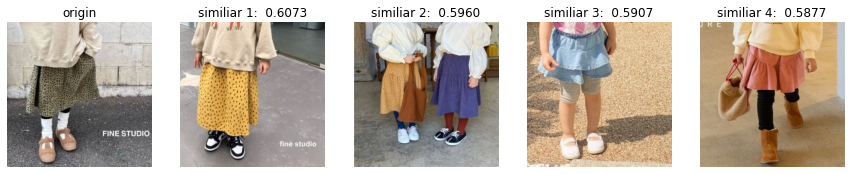

In [81]:
show_sim_image('2583.jpg')

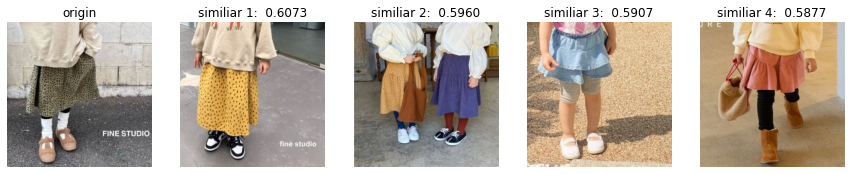

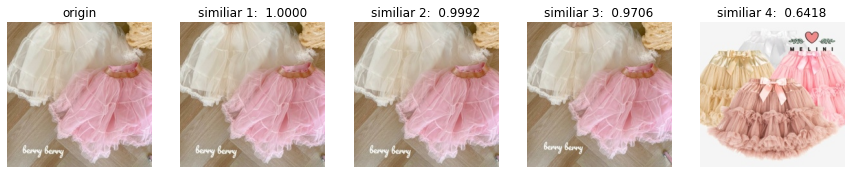

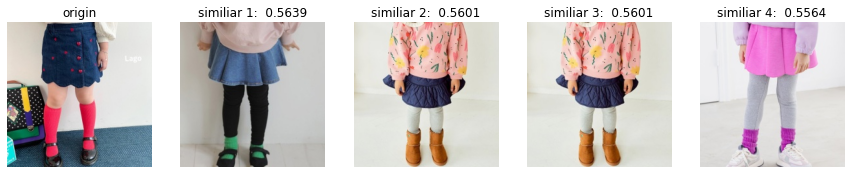

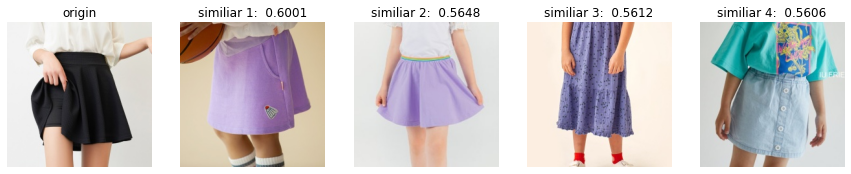

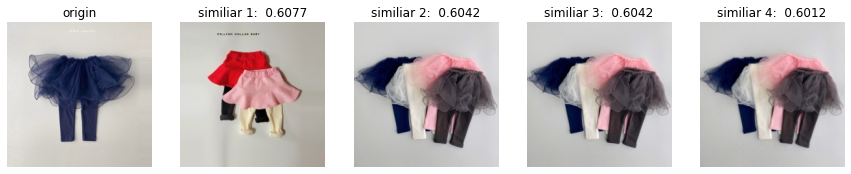

In [82]:
for filename in random_samples:
    show_sim_image(filename)
    print('\n')

In [83]:
# random sampleing
random_samples = np.random.choice(os.listdir(max_path), 10)
random_samples

array(['2158.jpg', '798.jpg', '2837.jpg', '283.jpg', '372.jpg', '211.jpg',
       '862.jpg', '2292.jpg', '737.jpg', '3102.jpg'], dtype='<U9')

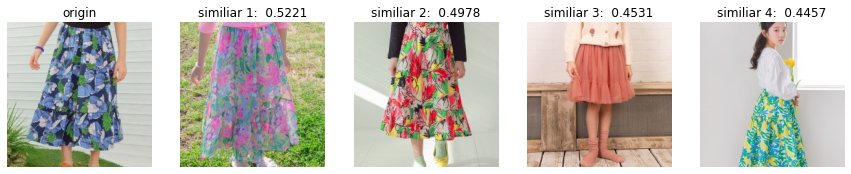

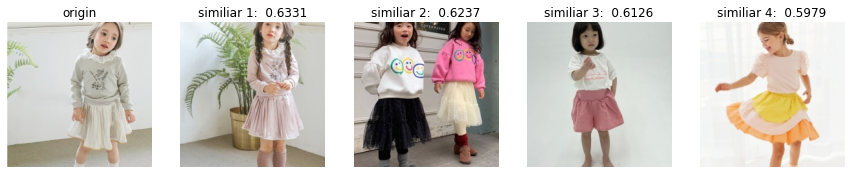

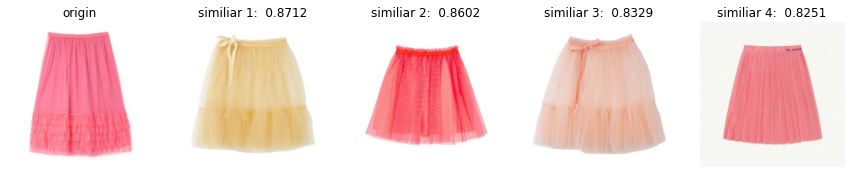

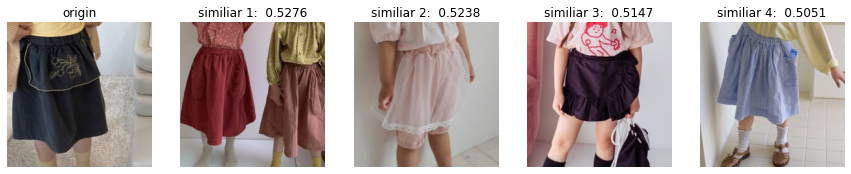

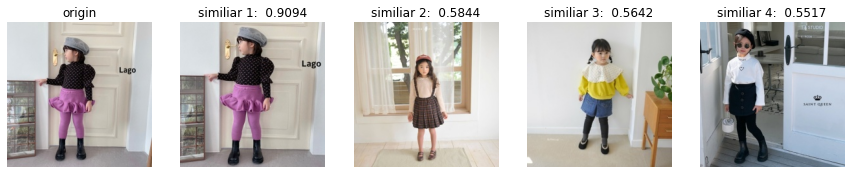

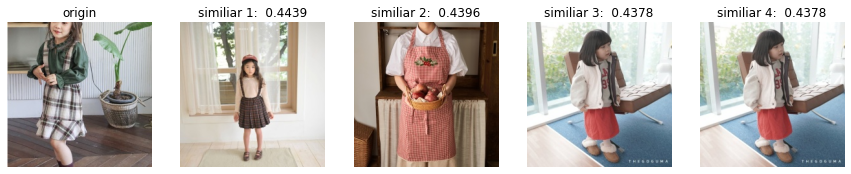

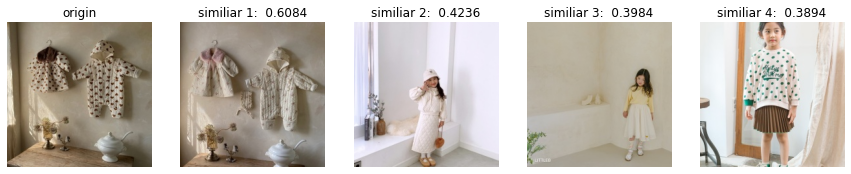

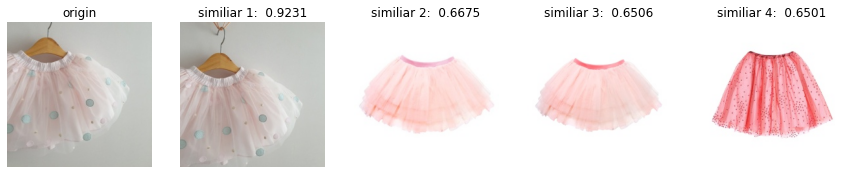

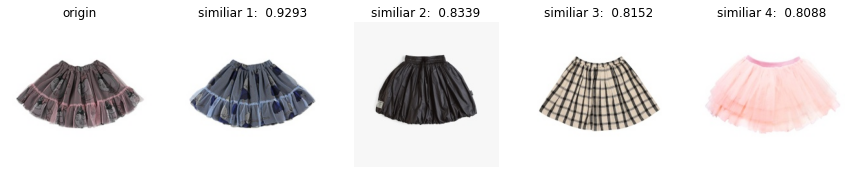

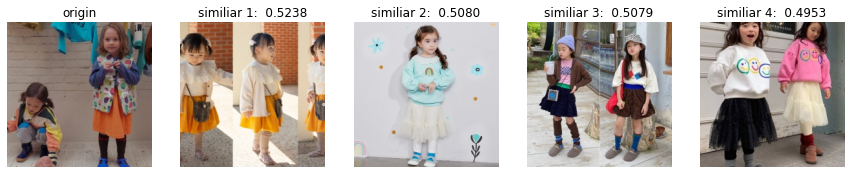

In [84]:
for filename in random_samples:
    show_sim_image(filename)
    print('\n')

---

#### VGG19